<!-- #### Minko KB. ITF. MPEI. Version 0.1 - August 2025 -->

# Итоговая программа для решения одномерного уравнения переноса (диффузии) и результаты ее тестирования (Часть 2, КМ2)

# Задание. 
1. Изучить программу.
2. Модифицировать программу для учета более общих ГУ 3-го рода (вместо двух параметров PhiA,PhiB добавить четыре параметра CoeffA, ValA, CoeffB, ValB).
3. Протестировать программу на задаче о теплопередаче через пластину для трех типов граничных условий (постановку и параметры придумать самим).
4. Протестировать программу на задаче о течении в плоском канале.

In [1]:
"""
Программа решения одномерного уравнения диффузии.
Свойства постоянны и однородны.
Граничные условия: первого рода  на обоих концах РО.
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
plt.style.use('ggplot')

def TDMA(A,b):
    ne = np.size(b) # количество уравнений
    P = np.zeros(ne)
    Q = np.zeros(ne)
    x = np.zeros(ne)
    P[0] = -A[0,1]/A[0,0]
    Q[0] = b[0]/A[0,0]
    #прямая прогонка
    for it in range(1,ne-1):
        P[it] = -A[it,it+1]/(A[it,it]+A[it,it-1]*P[it-1])
        Q[it] = (b[it] - A[it,it-1]*Q[it-1])/(A[it,it]+A[it,it-1]*P[it-1])
    Q[ne-1] = (b[ne-1] - A[ne-1,ne-2]*Q[ne-2])/(A[ne-1,ne-1]+A[ne-1,ne-2]*P[ne-2])
    #обратная прогонка
    x[ne-1] = Q[ne-1]
    for it in range(ne-2, -1, -1):
        x[it] = P[it]*x[it+1] + Q[it]
    return x

def Solve1D(Lx,Nx,GammaFun,AreaFun,CSourceFun,VSourceFun,CoeffA,ValA,CoeffB,ValB,Tol=1.0e-8):
    #I. создание сетки и определение геометрических параметров
    
    #грани КО
    XFace = np.linspace(0.0,Lx,Nx+1)
    #Ширина КО
    DX = XFace[1:Nx+1] - XFace[0:Nx]
    #Площади граней
    AFace = np.zeros(Nx+1)
    AFace[:] = AreaFun(XFace[:])
    #Создаем массив XP с размером Nx и инициализируем его нулевыми значениями .  
    XP = np.zeros(Nx)  
    XP = (XFace[0:Nx] + XFace[1:Nx+1])/2.0
    #объемы КО
    VolumeP = np.zeros(Nx)
    VolumeP[:] = DX[0:Nx]*(AFace[0:Nx] + AFace[1:Nx+1])/2.0
    
    #Объявление массивов
    Phi = np.zeros_like(XP,dtype=float)
    PhiOld = np.zeros_like(XP,dtype=float)
    Gamma = np.zeros(Nx,dtype=float)
    AlphaX = np.zeros(Nx,dtype=float)
    A = np.zeros((Nx,Nx),dtype=float)
    b = np.zeros(Nx,dtype=float)
    
    #итерации, они нужы если коэффициент диффузии или источник зависят от неизвестной величины
    err = 1.0
    ISweep = 0
    while err > Tol:
        PhiOld = Phi.copy()
        for i in range(0,Nx):
            Gamma[i] = GammaFun(XP[i],Phi[i])
        AlphaX[:] = 2.0*Gamma[:]/DX[:]
        
        #заполнений матрицы A и столбца b
        A[:,:] = 0.0
        b[:] = 0.0
        for i in range(0, Nx):
            
            if i != Nx - 1:
                anb = AlphaX[i] * AlphaX[i+1] / (AlphaX[i] + AlphaX[i+1]) * AFace[i+1]
                A[i,i] += anb
                A[i+1,i+1] += anb
                A[i+1,i] -= anb
                A[i,i+1] -= anb
            CVal, SVal = CSourceFun(XP[i], Phi[i]), VSourceFun(XP[i], Phi[i])
            b[i] += CVal * SVal * VolumeP[i]
            A[i,i] += CVal * VolumeP[i]
            
            # Левая граница
            if i == 0:   
                conduct = AlphaX[0] * CoeffA / (AlphaX[0] + CoeffA)
                b_val = ValA
                A[0, 0] += conduct * AFace[0]
                b[0] += conduct * AFace[0] * b_val

            # Правая граница
            if i == Nx-1:
                conduct = AlphaX[Nx-1] * CoeffB / (AlphaX[Nx-1] + CoeffB)
                b_val = ValB
                A[Nx-1, Nx-1] += conduct * AFace[Nx]
                b[Nx-1] += conduct * AFace[Nx] * b_val
        Phi = TDMA(A, b)
        err = np.max(np.abs(Phi - PhiOld))
        ISweep += 1

    return XP, Phi, ISweep, XFace, Gamma

In [2]:
#Параметры
Lx = 0.01 #длина расчетной области
Nx = 50 #количество контрольных объемов
Area = 1.0 #Площадь всех граней
Lambda = 0.1 #теплопроводность Вт/(м*К)
qv = 1.0e6    #внутреннее тепловыделение Вт/м^3
TA = 0.0 #температура слева
TB = 50.0 #температура справа

def calcArea(x):
    return 1.0
def calcGamma(XP,PhiP):
    return Lambda
def calcCSource(XP,PhiP):
    return 1.0e-20
def calcVSource(XP,PhiP):
    return qv/1.0e-20

# Условия 1 рода 

Количество итераций 2


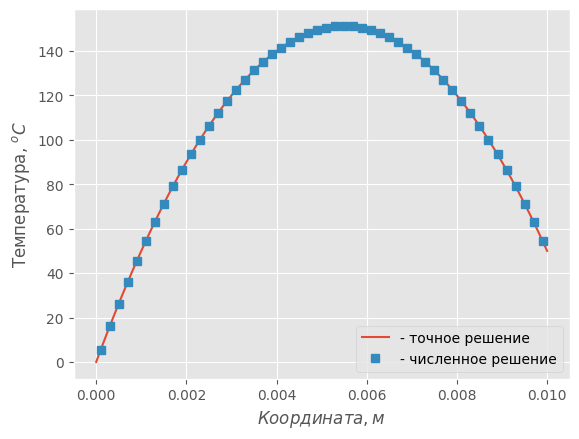

In [3]:
# Условия 1 рода 
CoeffA = 1e20
ValA = TA
CoeffB = 1e20
ValB = TB

# Решение задачи 
x, T, ISweep, _, _ = Solve1D(Lx, Nx, calcGamma, calcArea, calcCSource, calcVSource,CoeffA, ValA, CoeffB, ValB)
print(f"Количество итераций {ISweep}")

#Сравнение с точным решением
def fun_T_exact_TConst(x):
    """
    Функция возвращает точное решение для задачи с TConst
    """
    retVal = TA
    retVal += (TB-TA)*x/Lx
    retVal += qv*x*(Lx-x)/2/Lambda
    return retVal

#Считаем точное решение
x_exact = np.linspace(0.0,Lx,101)
t_exact_TConst = fun_T_exact_TConst(x_exact)

#Выводим и сравниваем
plt.plot(x_exact,t_exact_TConst,label='- точное решение')
plt.plot(x,T,'s',label='- численное решение')
plt.legend()     # отображаем легенду
plt.xlabel("$Координата, м$") # подписываем ось x
plt.ylabel("Температура, $^oC$") # подписываем ось y
plt.show()        # отображаем график

# Условия 2 рода 

Количество итераций 22


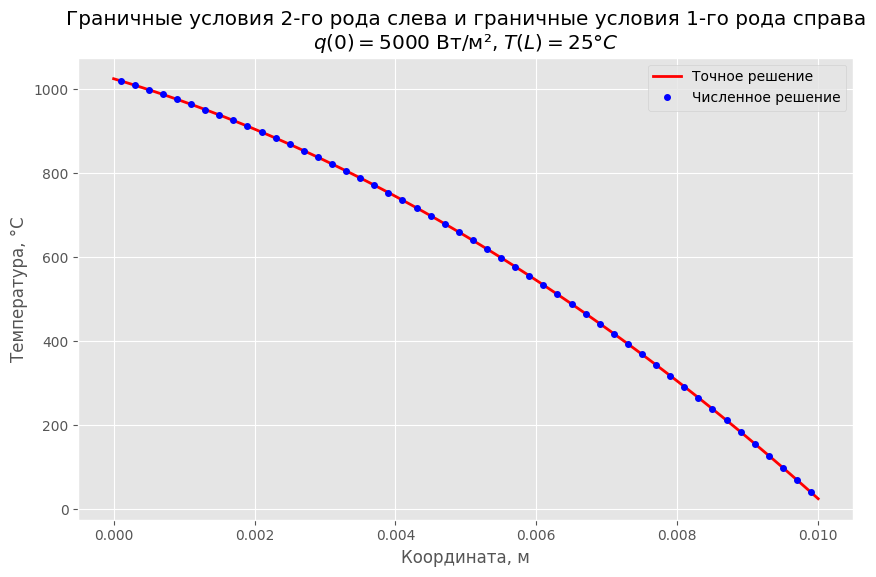

In [4]:
q_left = 5000.0  # тепловой поток на левой границе, Вт/м²
TB = 25.0        # температура на правой границе, °C

# Граничные условия: 2-й род слева, 1-й род справа
CoeffA = 1e-20    # 0 означает условие 2-го рода
ValA = q_left/1e-20    # значение потока
CoeffB = 1e20    # условие 1-го рода
ValB = TB        # температура

# Решение задачи 
x2, T2, ISweep2, _, _ = Solve1D(Lx, Nx, calcGamma, calcArea, calcCSource, calcVSource, CoeffA, ValA, CoeffB, ValB)
print(f"Количество итераций {ISweep}2")

# Точное решение для условий 2-го рода слева и 1-го рода справа
def exact_solution_type2(x):
    """
    Точное решение для:
    - Левый край: -Lambda * dT/dx = q_left (поток)
    - Правый край: T = TB
    - Внутренний источник: qv
    """
    C2 = -q_left / Lambda
    C1 = TB - C2*Lx + (qv/(2*Lambda))*Lx**2
    
    return C1 + C2*x - (qv/(2*Lambda))*x**2

# Точное решение
x_exact = np.linspace(0.0,Lx,101)
T_exact2 = exact_solution_type2(x_exact)

# Строим графики 
plt.figure(figsize=(10, 6))
plt.plot(x_exact, T_exact2, 'r-', label='Точное решение', linewidth=2)
plt.plot(x2, T2, 'bo', label='Численное решение', markersize=4)
plt.title('Граничные условия 2-го рода слева и граничные условия 1-го рода справа\n$q(0) = 5000$ Вт/м², $T(L) = 25°C$')
plt.xlabel('Координата, м')
plt.ylabel('Температура, °C')
plt.legend()
plt.grid(True)
plt.show()

# Условия 3 рода 

Количество итераций 2


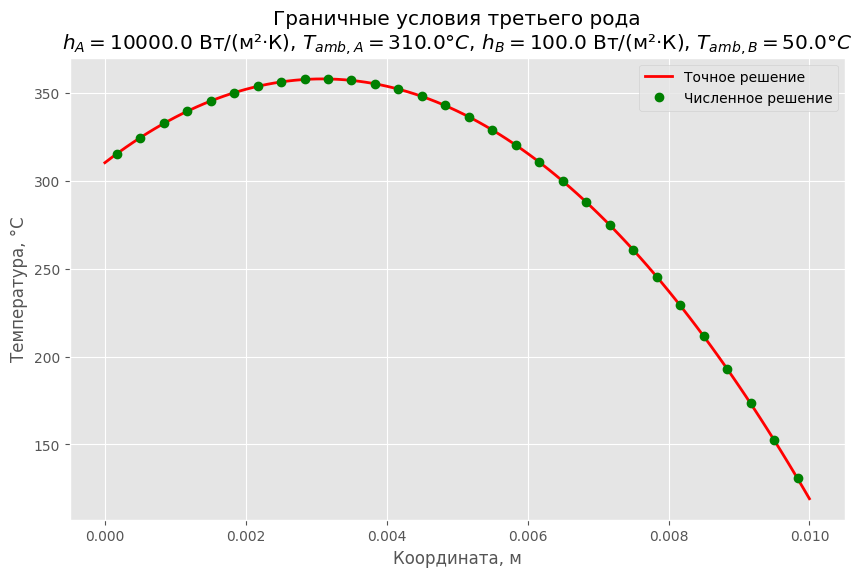

In [5]:
# Параметры для граничных условий третьего рода
hA = 10000.0      # Коэффициент теплоотдачи слева, Вт/(м²·К)
T_ambA = 310.0  # Температура окружающей среды слева, °C
hB = 100.0     # Коэффициент теплоотдачи справа, Вт/(м²·К)
T_ambB = 50.0   # Температура окружающей среды справа, °C

# Задаем граничные условия третьего рода
CoeffA = hA
ValA = T_ambA
CoeffB = hB
ValB = T_ambB

# Решаем задачу
x3, T3, ISweep3, _, _ = Solve1D(Lx, 30, calcGamma, calcArea, calcCSource, calcVSource, CoeffA, ValA, CoeffB, ValB)
print(f"Количество итераций {ISweep3}")


def exact_solution_type3(x):
    x0 = Lx*((0.5 + Lambda/(qv*Lx**2)*(T_ambB - T_ambA) + Lambda/(hB*Lx))/(1 + Lambda/Lx*(1/hA + 1/hB)))
    Tc1 = T_ambA + qv*x0/hA
    return qv*x/(2*Lambda)*(2*x0 - x) + Tc1

# Точное решение
x_exact = np.linspace(0.0, Lx, 101)
T_exact3 = exact_solution_type3(x_exact)

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(x_exact, T_exact3, 'r-', label='Точное решение', linewidth=2)
plt.plot(x3, T3, 'go', label='Численное решение', markersize=6)
plt.title('Граничные условия третьего рода\n'
          f'$h_A={hA}$ Вт/(м²·К), $T_{{amb,A}}={T_ambA}°C$, '
          f'$h_B={hB}$ Вт/(м²·К), $T_{{amb,B}}={T_ambB}°C$')
plt.xlabel('Координата, м')
plt.ylabel('Температура, °C')
plt.legend()
plt.grid(True)
plt.show()

# Течение в плоском канале 

Количество итераций: 2


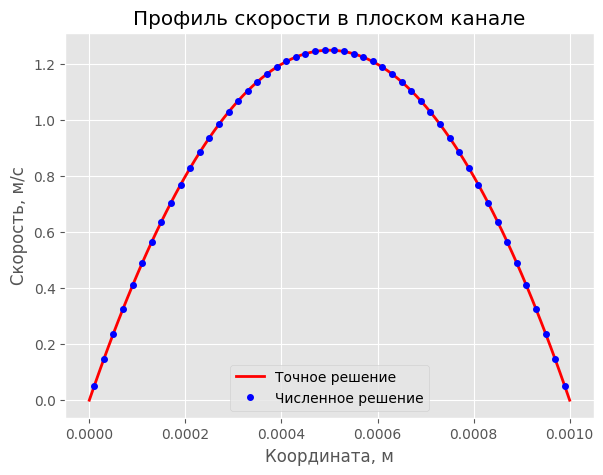

In [6]:
# Параметры для течения в плоском канале
h_channel = 0.0005       # Половина высоты канала [м]
Lx = h_channel * 2   # Полная высота канала [м]
mu = 0.001            # Вязкость воды [Па·с]
dpdx = -10000        # Градиент давления [Па/м]

# ГРАНИЧНЫЕ УСЛОВИЯ ПЕРВОГО РОДА (условия прилипания)
# Для условий прилипания используем очень большие коэффициенты
CoeffA = 1e20
ValA = 0
CoeffB = 1e20
ValB = 0

# Решаем задачу
x, u, ISweep, _, _ = Solve1D(Lx, Nx, calcGamma, calcArea, calcCSource, calcVSource, CoeffA, ValA, CoeffB, ValB)
print(f"Количество итераций: {ISweep}")

# Точное аналитическое решение для течения Пуазейля
def exact_solution_poiseuille(x):
    """Точное решение для течения в плоском канале с условиями прилипания"""
    return (-dpdx / (2 * mu)) * (h_channel**2 - (x - h_channel)**2)

# Точное решение
x_exact = np.linspace(0.0, Lx, 101)
u_exact = exact_solution_poiseuille(x_exact)

# Строим график
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x_exact, u_exact, 'r-', label='Точное решение', linewidth=2)
plt.plot(x, u, 'bo', label='Численное решение', markersize=4)
plt.title('Профиль скорости в плоском канале')
plt.xlabel('Координата, м')
plt.ylabel('Скорость, м/с')
plt.legend()
plt.grid(True)

# Задание
1) Предложить математическое описание задачи о стационарном
распределении температурного поля в прямом ребре. Предложить способ
обработки полученных результатов для определения эффективности ребра.
2) Реализовать граничные условия третьего рода в предоставленной
заготовке программы.
3) Продемонстрировать правильность выполненной модернизации
программы для учета граничных условий третьего рода. Например, сравнив
распределение температуры внутри пластины, с двух сторон которой заданы
граничные условия третьего рода.
4) Осознанно выбирая параметры, определить эффективность прямого
ребра. Сравнить результаты с известными теоретическими зависимостями.
При проведении расчетов доказать независимость решения от используемой
сетки.
5) Повторить предшествующие расчеты для трапециевидных ребер.
Главное отличие заключается в правильном определении параметров
контрольных объемов. Построить несколько кривых на номограмме,
представленной на рисунке 3.
6) Настроить программу для решения задач в цилиндрической
системе координат. Для этого нужно использовать допущение о том, что
площадь грани КО пропорциональна радиусу.
7) выполнить пункты 1)-4) для цилиндрического ребра.

# Прямоугольное ребро

Количество итераций: 2
Эффективность прямоуголного ребра через тепловой поток = 0.8244
Эффективность прямоугольного ребра по формуле (1) = 0.8611


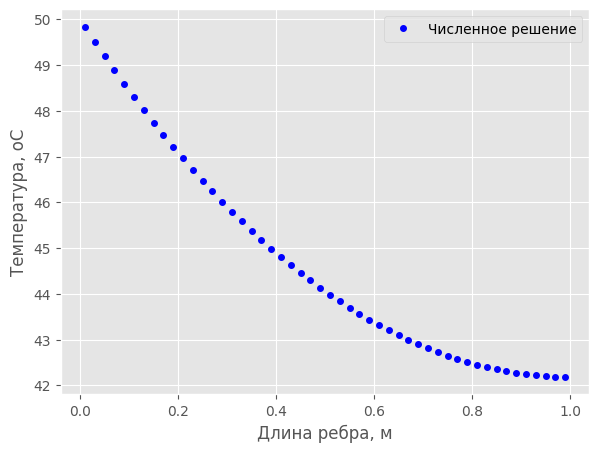

In [7]:
# Данные задачи 
T_st = 50
T_inf = 20
b = 0.003
l = 0.03
lamb = 10
alpha = 100
delta = 4e-3

def calcCSource(XP,PhiP):
    return 2 * alpha / b
def calcVSource(XP,PhiP):
    return T_inf

# ГРАНИЧНЫЕ УСЛОВИЯ ПЕРВОГО - ВТОРОГО РОДА 
CoeffA = 1e20
ValA = T_st
CoeffB = 1e-20
ValB = 0

# Решаем задачу
x5, T5, ISweep, _, _ = Solve1D(Lx, Nx, calcGamma, calcArea, calcCSource, calcVSource, CoeffA, ValA, CoeffB, ValB)
print(f"Количество итераций: {ISweep}")

# Строим график
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
# plt.plot(x_exact, u_exact, 'r-', label='Точное решение', linewidth=2)
plt.plot(x5 * 1000, T5, 'bo', label='Численное решение', markersize=4)
plt.xlabel('Длина ребра, м')
plt.ylabel('Температура, oC')
plt.legend()
plt.grid(True)

q = 0 
qid = 0
for i in range(0, Nx):
    q +=  (T5[i] - T_inf) * 2*alpha/(delta)
    qid +=  (T_st - T_inf) * 2*alpha/(delta)
etta = q/qid
print(f"Эффективность прямоуголного ребра через тепловой поток = {etta:.4f}")
    
# Эффективность прямоугольного ребра по формуле (1)
m0 = np.sqrt(2 * alpha / (delta * Lambda))
m0l = m0 * Lx
etapr = np.tanh(m0l) / m0l

print(f"Эффективность прямоугольного ребра по формуле (1) = {etapr:.4f}")

# Трапециевидное ребро

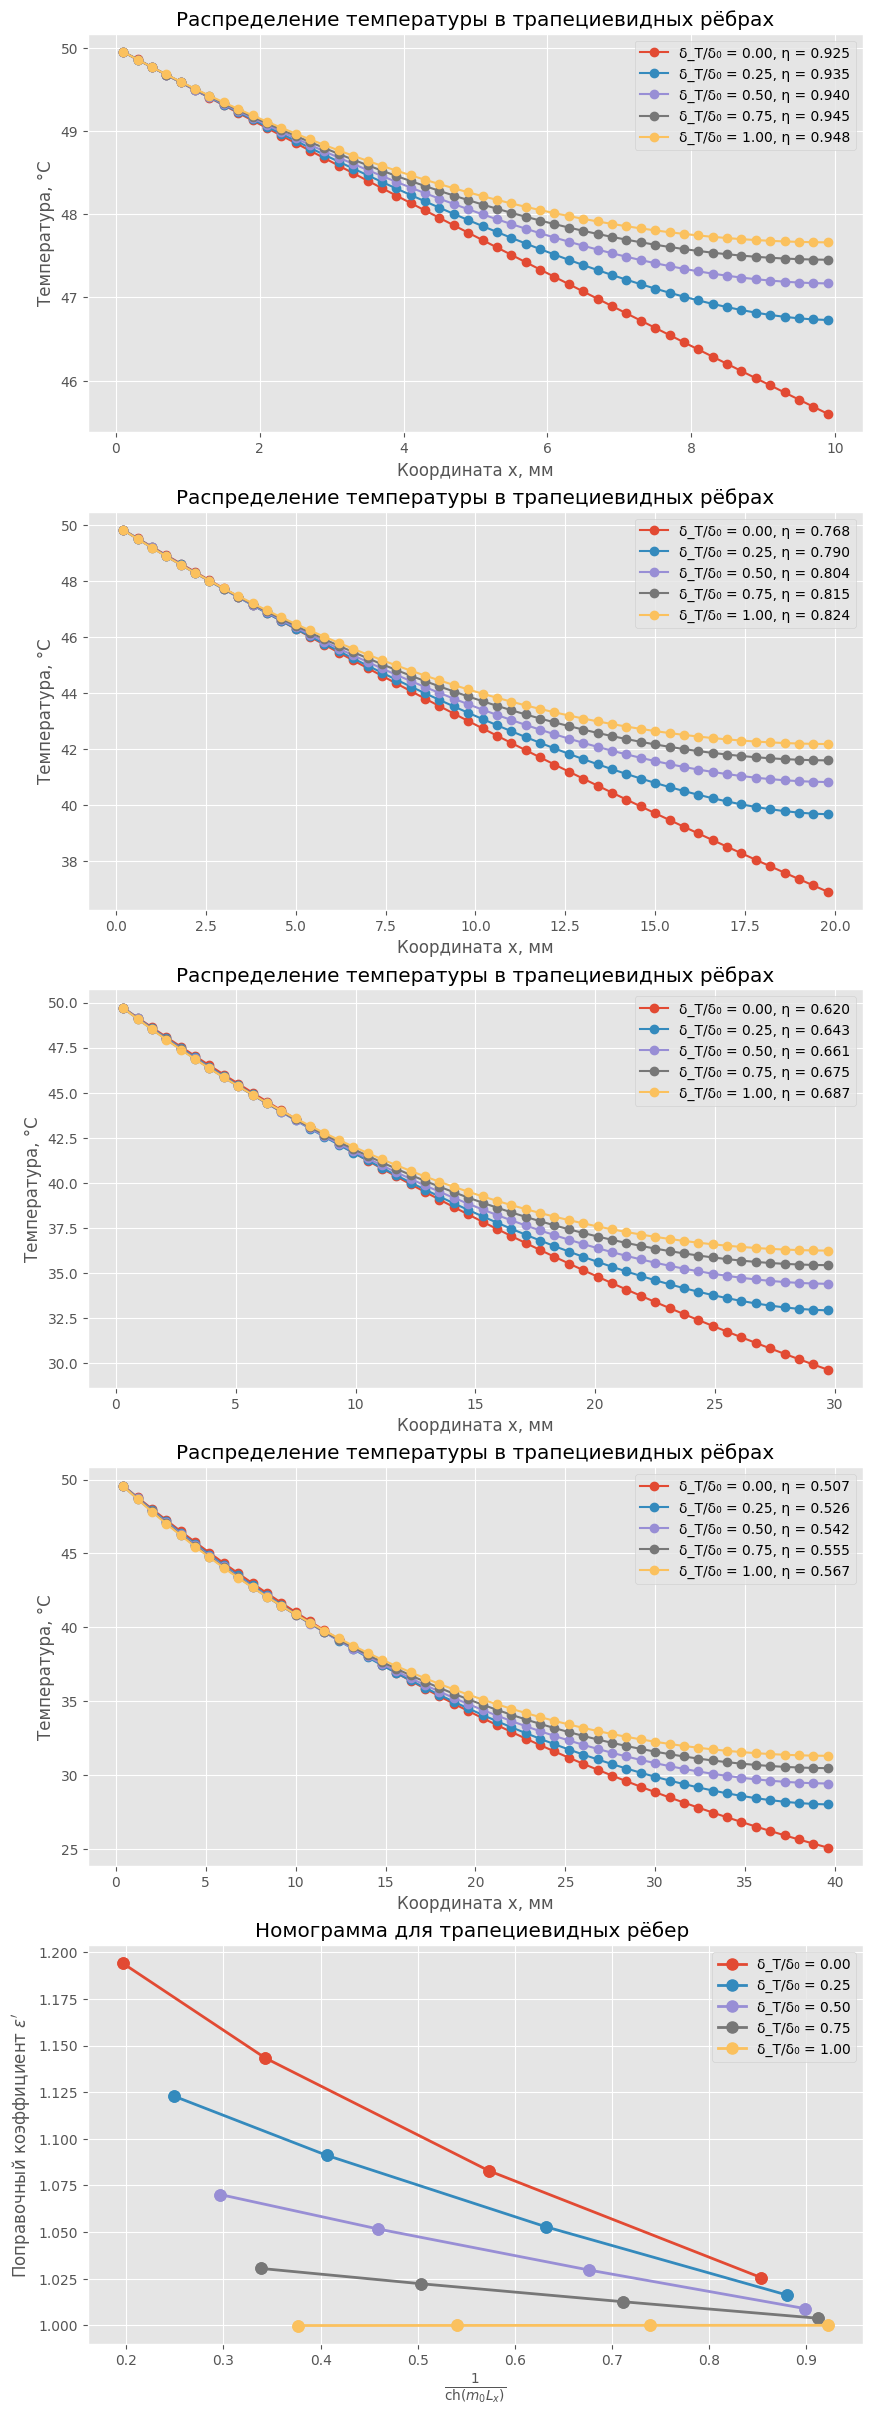

In [8]:
# Парметры задачи 
delta = 4e-3
Lx = np.array([0.01, 0.02, 0.03, 0.04])      # длина расчетной области
Nx = 50        # количество контрольных объемов
Lambda = 15     # теплопроводность
Tc = 50         # температура 
Tw = 20         # температура
alpha = 50

# Отношения оснований у трап. ребра
ratios = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

q_left = 0.0    # тепловой поток 
TB = Tc    # температура

# Граничные условия: 2-й род справа, 1-й род слева
CoeffA = 1e20           # условие 1-го рода
ValA = TB               # значение температуры
CoeffB = 1e-20          # условие 2-го рода
ValB = q_left/1e-20     # тепловой поток 

# Результы 
fig, ax = plt.subplots(nrows=len(Lx) + 1, ncols=1, figsize=(10, 30)) # 1 строка, 2 столбца

# Зададим словарь с клюючами - значениями ratios для построения номограммы 
nomogramm = {r:[] for r in ratios}

for idx, lx in enumerate(Lx):
    for r in ratios:
        deltaT = r * delta      # текущая толщина у вершины

        def calcArea(x):
            return delta - (delta - deltaT) * x / lx

        def calcGamma(x, T):
            return Lambda

        def calcCSource(x, T):
            return 2 * alpha / calcArea(x)

        def calcVSource(x, T):
            return Tw

        #  Решение 
        XP, T, sweeps, XFace, Gamma = Solve1D(lx, Nx, calcGamma, calcArea, calcCSource, calcVSource, CoeffA, ValA, CoeffB, ValB)

        # Расчёт эффективности через тепловой поток 
        DX = XFace[1:] - XFace[:-1]     # длины контрольных объёмов
        q_fact = 0.0
        q_ideal = 0.0
        for i in range(Nx):
            q_fact += 2 * alpha * (T[i] - Tw) * DX[i]
        q_ideal = 2 * alpha * (Tc - Tw) * lx
        eta_trap = q_fact / q_ideal
     
        # Расчет для номограммы  
        deltaT = r * delta
        delta_avg = (delta + deltaT) / 2.0
        m0 = np.sqrt(2 * alpha / (Lambda * delta_avg))
        m0l = m0 * lx
        eta_rect = np.tanh(m0l) / m0l
        eps_prime = eta_trap / eta_rect
        X = 1.0 / np.cosh(m0l)

         # Данные для номограммы 
        nomogramm[r].append((X, eps_prime))

        # График  
        ax[idx].plot(XP * 1000, T, 'o-', label=f'δ_T/δ₀ = {r:.2f}, η = {eta_trap:.3f}')
        ax[idx].set_xlabel('Координата x, мм')
        ax[idx].set_ylabel('Температура, °C')
        ax[idx].set_title('Распределение температуры в трапециевидных рёбрах')
        ax[idx].legend()
        ax[idx].grid(True)

        # Данные для номограммы 
        nomogramm[r].append((X, eps_prime))

# Построение номограммы ε
for r in ratios:
    '''
    Для построения номограммы зададим x и y, где x - это все первые значения в кортежах для данного ключа r, а y - все вторые значения.
    Итерируясь по всем ключам построим номограмму для кажого r(каждое r - какое то одно соотношение площадей)
    '''
    x = [n[0] for n in nomogramm[r]]
    y = [n[1] for n in nomogramm[r]]

    ax[len(Lx)].plot(x, y, 'o-', linewidth=2, markersize=8, label=f'δ_T/δ₀ = {r:.2f}')
    ax[len(Lx)].set_xlabel(r'$\frac{1}{\operatorname{ch}(m_0 L_x)}$', fontsize=14)
    ax[len(Lx)].set_ylabel(r"Поправочный коэффициент $\varepsilon'$")
    ax[len(Lx)].set_title(r'Номограмма для трапециевидных рёбер ')
    ax[len(Lx)].legend()
    ax[len(Lx)].grid(True)
    
plt.show()


# Цилиндрическое ребро

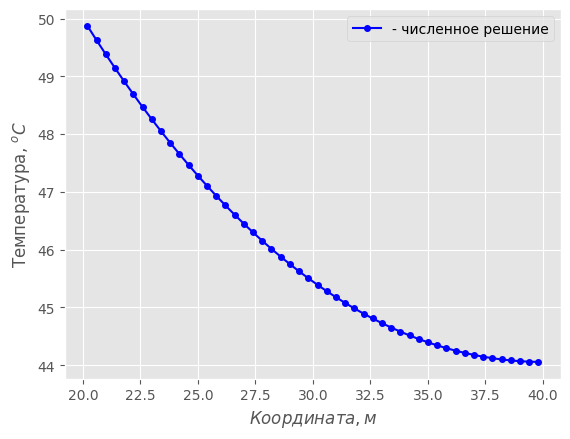

Эффективность цилиндрического ребра через тепловой поток = 0.8657
Эффективность цилиндрического ребра по формуле (1)= 0.8244


In [9]:
delta = 4e-3
Rin = 0.02
Rout = 0.04
Lx = Rout - Rin #длина расчетной области
Nx = 50 #количество контрольных объемов
Lambda = 15 #теплопроводность
Tc = 50 #температура 
Tw = 20 #температура
alpha = 50
def calcArea(x):
    return delta * np.pi * 2 * (Rin + x)
def calcGamma(XP,PhiP):
    return Lambda
def calcCSource(XP,PhiP):
    return 2*alpha/delta
def calcVSource(XP,PhiP):
    return Tw
#Граничные условия 

q_left = 0.0  # тепловой поток 
TB = Tc = 50     # температура

# Граничные условия: 2-й род справа, 1-й род слева
CoeffA = 1e20    # условие 1-го рода
ValA = TB    # значение температуры
CoeffB = 1e-20    # условие 2-го рода
ValB = q_left/1e-20        # тепловой поток 

def Solve1DCir(Rin,Rout,Nx,GammaFun,AreaFun,CSourceFun,VSourceFun,CoeffA,ValA,CoeffB,ValB,Tol=1.0e-6):
    #I. создание сетки и определение геометрических параметров
    #грани КО
    XFace = np.linspace(Rin,Rout,Nx+1)
    #Ширина КО
    DX = XFace[1:Nx+1] - XFace[0:Nx]
    #Площади граней
    AFace = np.zeros(Nx+1)
    AFace[:] = AreaFun(XFace[:])
    #Создаем массив XP с размером Nx и инициализируем его нулевыми значениями .  
    XP = np.zeros(Nx)  
    XP = (XFace[0:Nx] + XFace[1:Nx+1])/2.0
    #объемы КО
    VolumeP = np.zeros(Nx)
    R = Rin
    for i in range(Nx):
        VolumeP[i] = np.pi * delta * ((R+DX[i])**2 - R**2)
        R += DX[i]
    
    #Объявление массивов
    Phi = np.zeros_like(XP,dtype=float)
    PhiOld = np.zeros_like(XP,dtype=float)
    Gamma = np.zeros(Nx,dtype=float)
    AlphaX = np.zeros(Nx,dtype=float)
    A = np.zeros((Nx,Nx),dtype=float)
    b = np.zeros(Nx,dtype=float)
    
    #итерации, они нужы если коэффициент диффузии или источник зависят от неизвестной величины
    err = 1.0
    ISweep = 0
    while err > Tol:
        PhiOld = Phi.copy()
        for i in range(0,Nx):
            Gamma[i] = GammaFun(XP[i],Phi[i])
        AlphaX[:] = 2.0*Gamma[:]/DX[:]
        
        #заполнений матрицы A и столбца b
        A[:,:] = 0.0
        b[:] = 0.0
        for i in range(0, Nx):
            if i != Nx - 1:
                anb = AlphaX[i] * AlphaX[i+1] / (AlphaX[i] + AlphaX[i+1]) * AFace[i+1]
                A[i,i] += anb
                A[i+1,i+1] += anb
                A[i+1,i] -= anb
                A[i,i+1] -= anb
            CVal, SVal = CSourceFun(XP[i], Phi[i]), VSourceFun(XP[i], Phi[i])
            b[i] += CVal * SVal * VolumeP[i]
            A[i,i] += CVal * VolumeP[i]
        # Левая граница
            if i == 0:   
                conduct = AlphaX[0] * CoeffA / (AlphaX[0] + CoeffA)
                b_val = ValA
                A[0, 0] += conduct * AFace[0]
                b[0] += conduct * AFace[0] * b_val

        # Правая граница
            if i == Nx-1:
                conduct = AlphaX[Nx-1] * CoeffB / (AlphaX[Nx-1] + CoeffB)
                b_val = ValB
                A[Nx-1, Nx-1] += conduct * AFace[Nx]
                b[Nx-1] += conduct * AFace[Nx] * b_val
        Phi = TDMA(A, b)
        err = np.max(np.abs(Phi - PhiOld))
        ISweep += 1

    return XP, Phi, ISweep, DX, XFace, Gamma


x5, T5, ISweep5, DX, _, _ = Solve1DCir(Rin, Rout, Nx, calcGamma, calcArea, calcCSource, calcVSource, CoeffA, ValA, CoeffB, ValB)


#Выводим и сравниваем
plt.plot(x5 * 1000,T5,'bo-',markersize=4, label='- численное решение')
plt.legend()     # отображаем легенду
plt.xlabel("$Координата, м$") # подписываем ось x
plt.ylabel("Температура, $^oC$") # подписываем ось y
plt.show()        # отображаем график

q = 0 
qid = 0
R = Rin
for i in range(0, Nx):
    q +=  (T5[i] - Tw) * 2*alpha/(delta) * 2 * np.pi * ((R + DX[i])**2 - R**2)
    qid +=  (Tc - Tw) * 2*alpha/(delta) * 2 * np.pi * ((R + DX[i])**2 - R**2)
etta = q/qid

print(f"Эффективность цилиндрического ребра через тепловой поток = {etta:.4f}")
    
# Эффективность прямоугольного ребра по формуле (1)

m0 = np.sqrt(2 * alpha / (delta * Lambda))
m0l = m0 * Lx
etapr = np.tanh(m0l) / m0l

print(f"Эффективность цилиндрического ребра по формуле (1)= {etapr:.4f}")

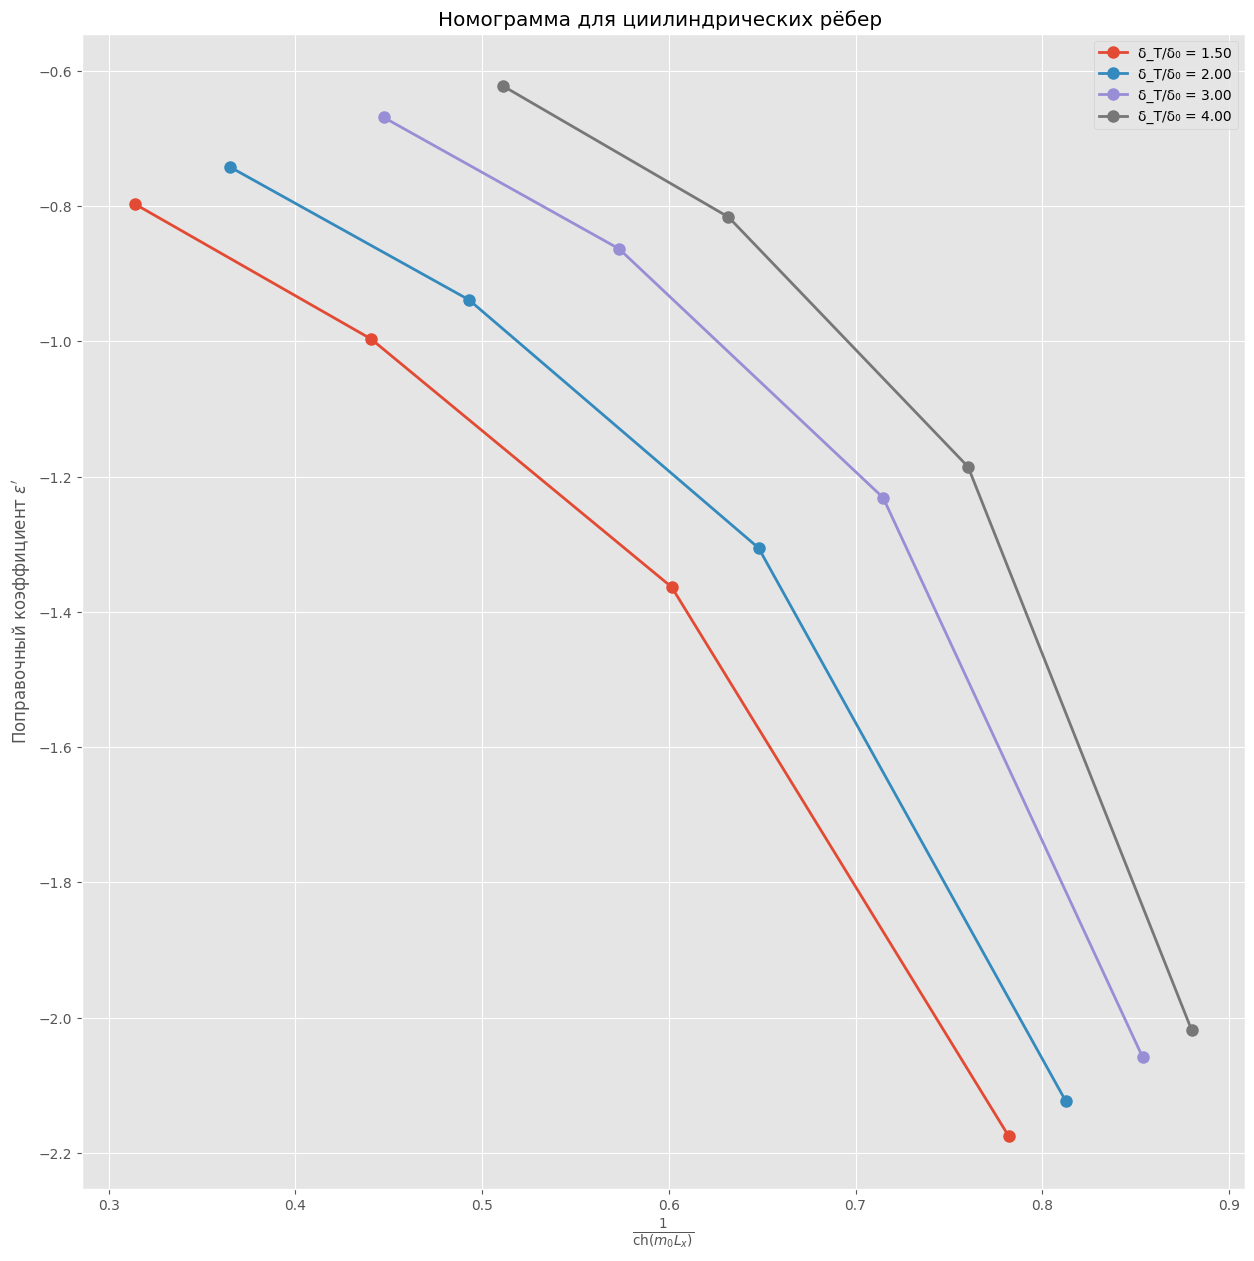

In [24]:
# Парметры задачи 
delta = 4e-3
Rin = 0.02
Rout = np.array([0.04, 0.05, 0.06, 0.07])
Lx = Rout - Rin      # длина расчетной области
Nx = 50        # количество контрольных объемов
Lambda = 15     # теплопроводность
Tc = 100        # температура 
Tw = 20         # температура
alpha = 50

# Отношения оснований у трап. ребра
ratios = np.array([1.5, 2.0, 3.0, 4.0])

q_left = 0.0    # тепловой поток 
TB = Tc    # температура

# Граничные условия
CoeffA = 1e20           # условие 1-го рода
ValA = TB               # значение температуры
CoeffB = 1e-20          # условие 2-го рода
ValB = q_left/1e-20     # тепловой поток 

# Результы 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15)) # 1 строка, 2 столбца

# Зададим словарь с клюючами - значениями ratios для построения номограммы 
nomogramm = {r:[] for r in ratios}

for idx, lx in enumerate(Lx):
    for r in ratios:
        deltaT = r * delta      # текущая толщина у вершины

        def calcArea(x):
             return delta * np.pi * 2 * (Rin + x) 
        
        def calcGamma(x, T):
            return Lambda

        def calcCSource(x, T):
            return 2 * alpha / calcArea(x)

        def calcVSource(x, T):
            return Tw

        #  Решение 
        XP, T, sweeps, DX, _, _ = Solve1DCir(Rout[idx], Rin, Nx, calcGamma, calcArea, calcCSource, calcVSource, CoeffA, ValA, CoeffB, ValB)

        # Расчёт эффективности через тепловой поток 
        DX = XFace[1:] - XFace[:-1]     # длины контрольных объёмов
        q_fact = 0.0
        q_ideal = 0.0
        
        for i in range(Nx):
            q_fact += 2 * alpha * (T[i] - Tw) * DX[i]
        q_ideal = 2 * alpha * (Tc - Tw) * lx
        eta_trap = q_fact / q_ideal
     
        # Расчет для номограммы  
        deltaT = r * delta
        delta_avg = (delta + deltaT) / 2.0
        m0 = np.sqrt(2 * alpha / (Lambda * delta_avg))
        m0l = m0 * (Rout[idx] - Rin)
        eta_rect = np.tanh(m0l) / m0l
        eps_prime = eta_trap / eta_rect
        X = 1.0 / np.cosh(m0l)
        
        # Данные для номограммы 
        nomogramm[r].append((X, eps_prime))

# Построение номограммы ε
for r in ratios:
    '''
    Для построения номограммы зададим x и y, где x - это все первые значения в кортежах для данного ключа r, а y - все вторые значения.
    Итерируясь по всем ключам построим номограмму для кажого r(каждое r - какое то одно соотношение площадей)
    '''
    x = [n[0] for n in nomogramm[r]]
    y = [n[1] for n in nomogramm[r]]

    plt.plot(x, y, 'o-', linewidth=2, markersize=8, label=f'δ_T/δ₀ = {r:.2f}')
    plt.xlabel(r'$\frac{1}{\operatorname{ch}(m_0 L_x)}$', fontsize=14)
    plt.ylabel(r"Поправочный коэффициент $\varepsilon'$")
    plt.title(r'Номограмма для циилиндрических рёбер ')
    plt.legend()
    plt.grid(True)
    
plt.show()


In [ ]:
# Парметры задачи 
delta = 4e-3
Rin = 0.02
Rout = np.array([0.04, 0.05, 0.06, 0.07])
Lx = Rout - Rin      # длина расчетной области
Nx = 50        # количество контрольных объемов
Lambda = 15     # теплопроводность
Tc = 100        # температура 
Tw = 20         # температура
alpha = 50

# Отношения оснований у трап. ребра
ratios = np.array([1.5, 2.0, 3.0, 4.0])

q_left = 0.0    # тепловой поток 
TB = Tc    # температура

# Граничные условия
CoeffA = 1e20           # условие 1-го рода
ValA = TB               # значение температуры
CoeffB = 1e-20          # условие 2-го рода
ValB = q_left/1e-20     # тепловой поток 




Расчет номограммы для цилиндрических трапециевидных ребер...

Расчет для Lx = 20.0 мм
  Отношение толщин δ_T/δ₀ = 1.5
    Пропущено: X=0.7820, ε'=-1.1703
  Отношение толщин δ_T/δ₀ = 2.0
    Пропущено: X=0.8126, ε'=-1.1382
  Отношение толщин δ_T/δ₀ = 3.0
    Пропущено: X=0.8537, ε'=-1.0872
  Отношение толщин δ_T/δ₀ = 4.0
    Пропущено: X=0.8800, ε'=-1.0415

Расчет для Lx = 30.0 мм
  Отношение толщин δ_T/δ₀ = 1.5
    Пропущено: X=0.6015, ε'=-1.3703
  Отношение толщин δ_T/δ₀ = 2.0
    Пропущено: X=0.6481, ε'=-1.3100
  Отношение толщин δ_T/δ₀ = 3.0
    Пропущено: X=0.7148, ε'=-1.2274
  Отношение толщин δ_T/δ₀ = 4.0
    Пропущено: X=0.7603, ε'=-1.1692

Расчет для Lx = 40.0 мм
  Отношение толщин δ_T/δ₀ = 1.5
    Пропущено: X=0.4405, ε'=-1.6258
  Отношение толщин δ_T/δ₀ = 2.0
    Пропущено: X=0.4929, ε'=-1.5301
  Отношение толщин δ_T/δ₀ = 3.0
    Пропущено: X=0.5734, ε'=-1.4021
  Отношение толщин δ_T/δ₀ = 4.0
    Пропущено: X=0.6319, ε'=-1.3177

Расчет для Lx = 50.0 мм
  Отношение толщин δ_T/

C:\Users\andre\AppData\Local\Temp\ipykernel_14156\1259712551.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12, loc='best')


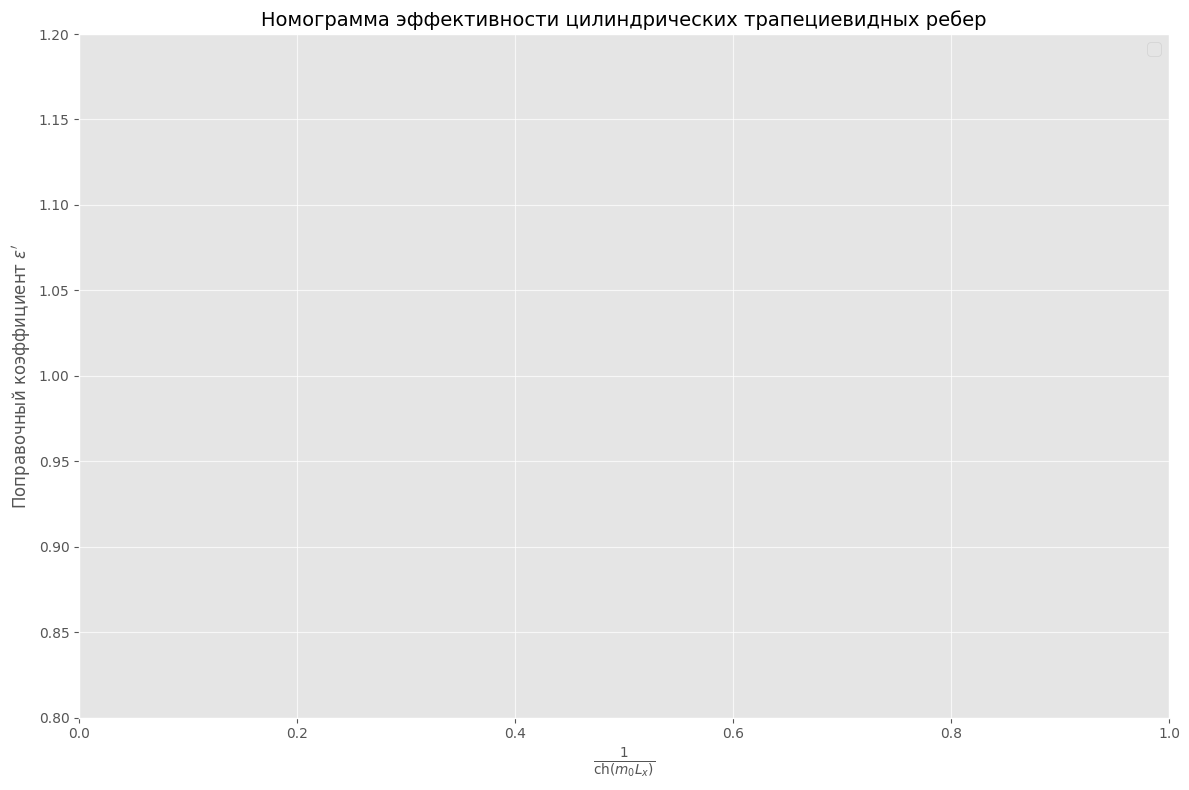

Расчет завершен. Номограмма построена.

Дополнительная информация:


In [ ]:
# Параметры из методических материалов
delta = 4e-3  # толщина у основания, м
Rin = 0.02    # внутренний радиус (основание ребра), м
Rout = np.array([0.04, 0.05, 0.06, 0.07])  # внешние радиусы, м
Lx = Rout - Rin  # высота ребер, м
Nx = 50         # количество контрольных объемов
Lambda = 15     # теплопроводность материала ребра, Вт/(м·К)
Tc = 100        # температура основания, °C
Tw = 20         # температура окружающей среды, °C
alpha = 50      # коэффициент теплоотдачи, Вт/(м²·К)

# Отношения толщин для трапециевидных ребер
ratios = np.array([1.5, 2.0, 3.0, 4.0])

# Создаем график для номограммы
plt.figure(figsize=(12, 8))


Bi = alpha * (Rout - Rin) / (2 * Lambda)
mo = 1


